In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from pathlib import Path
import pandas as pd
import tarfile
import urllib

def load_metadata():
  file_path = Path("data/train.csv")
  return pd.read_csv(file_path)
  
metadata = load_metadata()

def extract_eeg():
  eeg_dir = Path("../data/eeg")
  tarball_path = Path("data/eeg.tar.gz")
  if not tarball_path.is_file():
    url = 'https://dl.dropboxusercontent.com/scl/fi/5sina48c4naaxv6uze0fv/eeg.tar.gz?rlkey=r7ec191extynfcm8fy0tsiws5&dl=0'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as eeg_tarball:
      eeg_tarball.extractall()
    
extract_eeg()

metadata

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [4]:
# Add a unique id to each sample
from src.utils.utils import compute_signal_hash

def compute_unique_id(row):
  return str(compute_signal_hash(row))

metadata['unique_id'] = metadata.apply(compute_unique_id, axis=1)

cols = metadata.columns.tolist()
cols = [cols[-1]] + cols[:-1]
metadata = metadata[cols]
metadata


,unique_id,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,db76e9927,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,0e1116d9d,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,8ec6d3c8c,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,662b0bd39,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,ca946aadb,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,368247dd8,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,a7a60ad75,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,97f63909c,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,a5399830b,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [5]:
import dask.dataframe as dd
from src.utils import compute_signal_hash

channel_order = ['Fp1', 'Fp2',
            'F7', 'F3', 'Fz', 'F4', 'F8', 
            'T3', 'C3', 'Cz', 'C4', 'T4', 
            'T5', 'P3', 'Pz', 'P4', 'T6', 
            'O1', 'O2',
          ]

def load_signals(metadata):
  rows = len(metadata)
  eeg_list = []

  for row in range(0,rows):
    sample = metadata.iloc[row]
    f_name = f'data/eeg/{sample.eeg_id}.parquet'
    eeg = pd.read_parquet(f_name)[channel_order]
    eeg_offset = int(sample.eeg_label_offset_seconds)

    eeg['unique_id'] = sample['unique_id']
    eeg = eeg.set_index('unique_id')

    eeg = eeg.iloc[eeg_offset*200:(eeg_offset+50)*200]
    eeg_list.append(eeg)

  return dd.concat(eeg_list)

ddf = load_signals(metadata)


In [6]:
df = ddf.compute()
eeg_ids = list(set(df.index))
df

,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
unique_id,,,,,,,,,,,,,,,,,,,
db76e9927,-14.780000,-33.049999,-8.910000,-5.600000,-21.650000,1.780000,-26.129999,9.850000,-16.209999,-33.310001,-17.459999,3.22,-5.170000,-14.370000,-13.94,-24.629999,-4.620000,-27.780001,-17.980000
db76e9927,-8.100000,-34.610001,-26.570000,-2.770000,-20.350000,0.660000,-35.130001,13.400000,-16.600000,-36.060001,-17.309999,15.12,-3.140000,-15.580000,-15.91,-25.969999,-1.740000,-28.480000,-20.629999
db76e9927,-3.530000,-34.709999,17.120001,15.570000,-19.110001,-0.770000,-24.709999,30.219999,-8.930000,-32.369999,-23.840000,-2.82,14.670000,-6.310000,-8.61,-20.760000,4.840000,-18.500000,-10.460000
db76e9927,-3.370000,-29.330000,13.520000,11.710000,-20.629999,-4.140000,10.330000,24.660000,-10.640000,-33.750000,-32.400002,-4.81,14.880000,-5.840000,-11.61,-24.910000,-2.940000,-18.680000,-13.950000
db76e9927,-3.830000,-27.459999,14.320000,-2.420000,-20.000000,-3.300000,-9.990000,19.590000,-12.090000,-35.860001,-27.650000,7.83,4.900000,-11.270000,-16.00,-27.860001,-4.780000,-25.540001,-20.190001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
bbdf2f28e,-39.990002,-11.380000,14.590000,-20.500000,-15.240000,-23.340000,-57.529999,-12.530000,7.420000,-20.930000,-16.010000,1.68,-3.070000,-1.150000,2.43,-0.170000,-23.500000,-6.850000,3.350000
bbdf2f28e,-74.470001,-50.410000,-10.230000,-46.110001,-35.630001,-53.380001,-85.099998,-32.070000,-14.630000,-38.250000,-40.669998,-25.49,-22.780001,-22.990000,-15.43,-26.559999,-49.869999,-26.160000,-22.389999
bbdf2f28e,-66.209999,-31.180000,-4.690000,-39.560001,-26.389999,-49.680000,-75.089996,-27.030001,-7.510000,-28.959999,-32.930000,-10.00,-10.790000,-11.880000,-5.56,-20.100000,-42.110001,-11.150000,-14.310000


In [7]:
df = df.interpolate(method='linear', axis=0)

In [8]:
# Apply filtering
from src.preprocessing.preprocessing import bp_filter, notch_filter
from scipy.signal import iirnotch, filtfilt, butter

def apply_notch_filter(df, fs, f0):
  filtered = df.copy()
  b,a = iirnotch(f0, 30, fs)
  for column in filtered.columns:
    filtered[column] = filtfilt(b, a, df[column])
  return filtered

def apply_bp_filter(df, fs, lowcut, highcut):
  filtered = df.copy()
  nyq = 0.5*fs
  low = lowcut / nyq
  high = highcut/nyq
  b,a = butter(5, [low,high], btype='band')
  for channel in filtered.columns:
    filtered[channel] = filtfilt(b,a, df[channel])
  return filtered


filtered_data = apply_notch_filter(df, 200, 60)
filtered_data = apply_bp_filter(filtered_data, 200, 0.5, 50)

/opt/anaconda3/envs/340-project/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from src.preprocessing.preprocessing import wavelet_transform
preprocessed_data = wavelet_transform(filtered_data, 2, basis='bior3.3')

Extracting top 3 channels based on max variance for all samples
- 1000 samples computation duration = approx. 15 minutes

In [11]:
from src.feature_extraction import calculate_all_samples

top_channels_df = calculate_all_samples(filtered_data, eeg_ids, len(eeg_ids))
top_channels_df

,0,1,2
ea8c8ff1d,Fp1,Fp2,F7
ab2192b99,Fp1,F3,C4
742f5c6f8,T5,Cz,Fp2
ec2a8e98d,F3,Fz,Fp2
128af48d7,Fp1,F7,Fp2
...,...,...,...
c8f15b72c,O1,Fp2,O2
fcdeb3c61,T5,T3,F7
d70dc21ff,T5,T3,F7
c9eac1abb,Fz,Fp1,F7


Extracting Statistical Features from every sample with extraction function
- 1000 samples computation duration = approx. 20 minutes

In [12]:
from src.feature_extraction import extract_features_all_samples

features_df = extract_features_all_samples(df, top_channels_df)
features_df

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow
ea8c8ff1d,28.265432,-25.888586,179.440002,-119.363335,800.207316,-27.736666,0.818092,6.052751,5.142747,3799081.916667,151434861318.804657
ab2192b99,4792.281413,3510.529622,11066.130208,-1183.483358,22965962.666667,-1.081667,0.615309,1.378664,0.944114,727267729386154.625,3528978283398595.5
742f5c6f8,999.982925,-110.127508,1619.33669,-1978.936666,1399023.492188,-106.486669,-0.202248,2.516245,4.484474,4511101281749.333008,141123265352961.09375
ec2a8e98d,60.081617,-14.156246,183.633331,-289.553335,3609.926025,-10.071667,-0.397834,3.683117,5.104157,48038181.333333,403133374308.124023
128af48d7,200.503413,6.661311,469.07667,-471.799998,40303.445312,7.198333,0.013467,1.778338,4.451608,2901026133.333333,4058811672803.115234
...,...,...,...,...,...,...,...,...,...,...,...
c8f15b72c,4686.134913,2229.874634,15138.216309,-5908.653514,62971472.746094,-63.168331,0.285524,3.50673,4.633801,36924720343035648.0,7811415466364385.0
fcdeb3c61,32.371367,-17.741751,95.139999,-128.016668,1048.209798,-18.536666,0.082604,3.035918,5.05153,3340809.166667,148174600613.440399
d70dc21ff,1116.635661,133.024516,9099.566732,-2084.973307,1247047.708333,-30.57,4.227517,24.883479,5.526938,38710994621781.335938,126501706585059.546875
c9eac1abb,844.711157,-1.067206,2375.089996,-2337.86997,1924931.93929,-14.886667,0.535138,3.212038,4.747395,18307894782165.332031,192516662886371.09375


Setting up Feature Data and Target Data for correct format to split data and Input to Microsoft's Light Gradient Boosting Machine (LGBM)

In [13]:
# Setup feature table
# input_df = pd.merge(features_df, metadata[['unique_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']], left_index=True, right_on='unique_id')
input_df = pd.merge(features_df, metadata[['unique_id', 'expert_consensus']], left_index=True, right_on='unique_id')
input_df = input_df.set_index('unique_id')
input_df

,std,mean,max,min,var,med,skew,kurt,ent,mom,pow,expert_consensus
unique_id,,,,,,,,,,,,
ea8c8ff1d,28.265432,-25.888586,179.440002,-119.363335,800.207316,-27.736666,0.818092,6.052751,5.142747,3799081.916667,151434861318.804657,GRDA
ab2192b99,4792.281413,3510.529622,11066.130208,-1183.483358,22965962.666667,-1.081667,0.615309,1.378664,0.944114,727267729386154.625,3528978283398595.5,GPD
742f5c6f8,999.982925,-110.127508,1619.33669,-1978.936666,1399023.492188,-106.486669,-0.202248,2.516245,4.484474,4511101281749.333008,141123265352961.09375,GRDA
ec2a8e98d,60.081617,-14.156246,183.633331,-289.553335,3609.926025,-10.071667,-0.397834,3.683117,5.104157,48038181.333333,403133374308.124023,GPD
128af48d7,200.503413,6.661311,469.07667,-471.799998,40303.445312,7.198333,0.013467,1.778338,4.451608,2901026133.333333,4058811672803.115234,Other
...,...,...,...,...,...,...,...,...,...,...,...,...
c8f15b72c,4686.134913,2229.874634,15138.216309,-5908.653514,62971472.746094,-63.168331,0.285524,3.50673,4.633801,36924720343035648.0,7811415466364385.0,Other
fcdeb3c61,32.371367,-17.741751,95.139999,-128.016668,1048.209798,-18.536666,0.082604,3.035918,5.05153,3340809.166667,148174600613.440399,GRDA
d70dc21ff,1116.635661,133.024516,9099.566732,-2084.973307,1247047.708333,-30.57,4.227517,24.883479,5.526938,38710994621781.335938,126501706585059.546875,LPD


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


x = input_df.iloc[:, :11].astype(float)
y = input_df[['expert_consensus']].to_numpy().flatten()

categories = ['Seizure', 'LPD', 'GPD', 'LRDA', 'GRDA', 'Other']

le = LabelEncoder()
le.fit(categories)
y = le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=92)

In [39]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

params = {
    'objective': 'multiclass',
    'num_class': 6,
    'boosting_type': 'gbdt',
    'metric': 'multi_logloss',
    'num_leaves': 121,
    'learning_rate': 0.018623105710769177,
    'feature_fraction': 1.0,
    'bagging_fraction': 0.756777580360579,
    'max_depth': 8,
    'verbose': -1
}
lgb_model = lgb.LGBMClassifier(**params)
lgb_model.fit(X_train, y_train)

LGBMClassifier(bagging_fraction=0.756777580360579, feature_fraction=1.0,
               learning_rate=0.018623105710769177, max_depth=8,
               metric='multi_logloss', num_class=6, num_leaves=121,
               objective='multiclass', verbose=-1)

Inputting Parameters for LGBM Model
- parameters were obtained by observing similiar implementation in same competition project using LGBM library. (see report doc --> citations/acknowledgements for more details) 
- Slight adjustments to parameters applied to fit our implementation

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = lgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.445

Splitting Data 80/20 and adjusting params to obtain training and testing sets

Training our LGBM model on the training data and evaluating it on the test data - Probabilities for each target label are obtained and Displayed

Generating Confusion Matrix with predicted labels and true labels

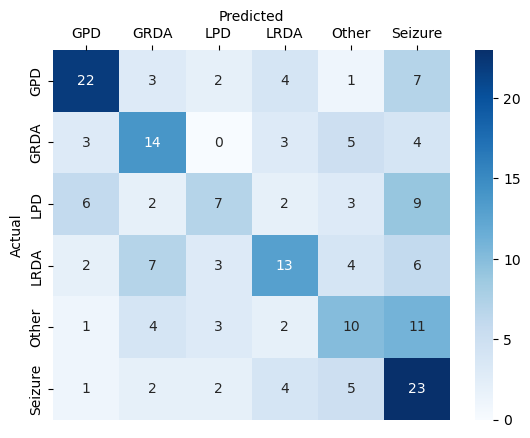

In [37]:
# Generate confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = lgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm)

cm_df.columns = le.inverse_transform([0,1,2,3,4,5]).tolist()
cm_df.index = le.inverse_transform([0,1,2,3,4,5]).tolist()

hm = sns.heatmap(cm_df, annot=True, cmap='Blues')
hm.set_xlabel('Predicted')
hm.set_ylabel('Actual')

hm.xaxis.set_label_position('top')
hm.xaxis.tick_top()

Generating result metrics to evaluate our multiclassification model

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate the metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Accuracy: 0.445
Precision: 0.4532386204481793
Recall: 0.445
F1 Score: 0.4391303116441997


In [36]:
y_pred_proba = lgb_model.predict_proba(X_test)

# Predicted probabilities to DataFrame
pred_df = pd.DataFrame(y_pred_proba, columns=['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'])
pred_df['eeg_id'] = X_test.index
pred_df = pred_df[['eeg_id', 'seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']]
pred_df

,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,910e3c34c,0.097536,0.084833,0.090908,0.030955,0.346261,0.349507
1,f92975586,0.139840,0.134059,0.099701,0.060111,0.205247,0.361041
2,629b6e929,0.138684,0.156386,0.083916,0.086922,0.395036,0.139054
3,126e6b01e,0.227658,0.195450,0.173648,0.082875,0.145911,0.174458
4,c8f15b72c,0.139357,0.135749,0.157779,0.050412,0.314091,0.202611
...,...,...,...,...,...,...,...
195,1a8af76b4,0.049302,0.216597,0.106638,0.207753,0.253630,0.166081
196,b4b3590a8,0.280740,0.151469,0.180770,0.200172,0.134257,0.052593
197,258d36d43,0.709568,0.038430,0.066795,0.048283,0.064495,0.072429
198,0d7ff7b7c,0.071856,0.160815,0.359431,0.067804,0.194220,0.145875


In [20]:
# File created to test the correctness of extracted values using MATLAB
# Save Fp1 channel data into a MATLAB file
# import scipy.io
# scipy.io.savemat('Fp1_data.mat', {'Fp1_data': sig1['Fp1']})